
## Image-Classification-using-CIFAR-10-dataset:


<img src="https://miro.medium.com/v2/resize:fit:798/1*rlzLKk9a_9mT1UeXjOvomw.png" alt="cifar" width="500">

The CIFAR-10 Dataset is an important image classification dataset. It consists of 60000 32x32 colour images in 10 classes (airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks), with 6000 images per class. There are 50000 training images and 10000 test images.

## The GOALs of this project are to:
* Implement Convolutional Neural Networks (CNN) classifiers using GPU-enabled PyTorch
* Learn how to make a model from scratch with PyTorch
* reduce overfitting by using:
    1. Data Augmentation
    2. Normalization
    3. Batch Normalization
    4. Dropout



## 1. Importing The Libraries

In [77]:
import torchvision
from torch import nn
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

## 2. Transforms
`transforms.RandomCrop(32, padding=4)`
→ Randomly crops the image to size 32×32, after padding it with 4 pixels on each side.
→ Helps model learn translation invariance (shifting object around).

`transforms.RandomHorizontalFlip()`
→ Randomly flips image left–right (50% chance).
→ Helps model learn symmetry.

`transforms.ToTensor()`
→ Converts a PIL image (values 0–255) into a PyTorch tensor (values 0–1).

`transforms.Normalize(mean, std)`
→ Normalizes each channel:

Why do this?

* Training transform = data augmentation + normalization → improves generalization, reduces overfitting.

* Testing transform = only normalization → ensures fair comparison with trainings.

In [78]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## 3. Loading The Data and Appling The Transforms

In [79]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform= transform_test)

##  4. Getting Familiar With The Data

* Using `.shape`
 and `.classes`


In [80]:
image, label = train_set[2]
image.shape, label

(torch.Size([3, 32, 32]), 9)

In [81]:
classes_names = train_set.classes
classes_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

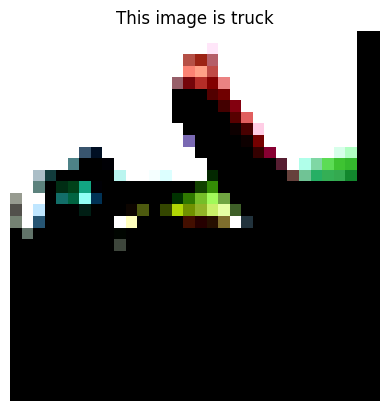

In [82]:
plt.imshow(image.permute(1,2,0))
plt.title(f"This image is {classes_names[label]}")
plt.axis(False)

In [83]:
train_set.data.shape, test_set.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## 5. Using DataLoader
Dataloader is used to turn the data into batches

### Why batching is important?

1. Makes training faster (parallelized on GPU).

2. Reduces memory usage (don’t load the whole dataset at once).

2. Improves gradient estimation → instead of 1 image (too noisy) or whole dataset (too slow), we use a mini-batch.

In [84]:
train_dataLoader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataLoader = DataLoader(test_set, batch_size=32, shuffle=False)

In [85]:
train_batch,label = next(iter(train_dataLoader))
train_batch.shape, label.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

### What it does?

torch.cuda.is_available() → checks if a GPU (CUDA-enabled NVIDIA GPU) is available.

If yes → uses "cuda" (GPU).

If no → falls back to "cpu".

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 6. Model Architecture


* The network starts by extracting features from the input image using stacked convolutional layers with batch normalization and pooling.

* The extracted features are then flattened and classified using fully connected layers with dropout to improve generalization.

* This architecture is lightweight but effective for CIFAR-10, typically reaching 75–80% test accuracy with proper training.

In [87]:
class simpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU()
)
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
  def forward(self,x):
    x = self.features(x)
    x = self.classifier(x)
    return x

In [88]:
model_1 = simpleCNN().to(device)

In [89]:
!pip install torchinfo

In [90]:
from torchinfo import summary
summary(model_1, input_size=(32, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
simpleCNN                                [32, 10]                  --
├─Sequential: 1-1                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 32, 32, 32]          896
│    └─BatchNorm2d: 2-2                  [32, 32, 32, 32]          64
│    └─ReLU: 2-3                         [32, 32, 32, 32]          --
│    └─MaxPool2d: 2-4                    [32, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [32, 64, 16, 16]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 16, 16]          128
│    └─ReLU: 2-7                         [32, 64, 16, 16]          --
│    └─MaxPool2d: 2-8                    [32, 64, 8, 8]            --
│    └─Conv2d: 2-9                       [32, 128, 8, 8]           73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 8, 8]           256
│    └─ReLU: 2-11                        [32, 128, 8, 8]           --
├─Se

## 7. Picking The Right Loss Function and Optimizer

In [91]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

## 8. Making The Train and Test Functions

In [92]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [93]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [94]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    return results

In [95]:
model_1_results = train(model_1,train_dataLoader,test_dataLoader,optimizer,loss_fn,20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7231 | train_acc: 0.3528 | test_loss: 1.3031 | test_acc: 0.5139
Epoch: 2 | train_loss: 1.4248 | train_acc: 0.4779 | test_loss: 1.0705 | test_acc: 0.6087
Epoch: 3 | train_loss: 1.2806 | train_acc: 0.5402 | test_loss: 0.9564 | test_acc: 0.6552
Epoch: 4 | train_loss: 1.1699 | train_acc: 0.5845 | test_loss: 0.8900 | test_acc: 0.6869
Epoch: 5 | train_loss: 1.0997 | train_acc: 0.6122 | test_loss: 0.8457 | test_acc: 0.7018
Epoch: 6 | train_loss: 1.0425 | train_acc: 0.6344 | test_loss: 0.8341 | test_acc: 0.7086
Epoch: 7 | train_loss: 1.0032 | train_acc: 0.6515 | test_loss: 0.7702 | test_acc: 0.7304
Epoch: 8 | train_loss: 0.9549 | train_acc: 0.6691 | test_loss: 0.7444 | test_acc: 0.7446
Epoch: 9 | train_loss: 0.9187 | train_acc: 0.6826 | test_loss: 0.7246 | test_acc: 0.7503
Epoch: 10 | train_loss: 0.8675 | train_acc: 0.7047 | test_loss: 0.7054 | test_acc: 0.7550
Epoch: 11 | train_loss: 0.8394 | train_acc: 0.7136 | test_loss: 0.6825 | test_acc: 0.7677
Epoch: 12 | train_l

## 9. Plotting train-test Loss and train-test Accuracy  
* These curves are crucial for diagnosing underfitting, overfitting, or good fit.

In [96]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

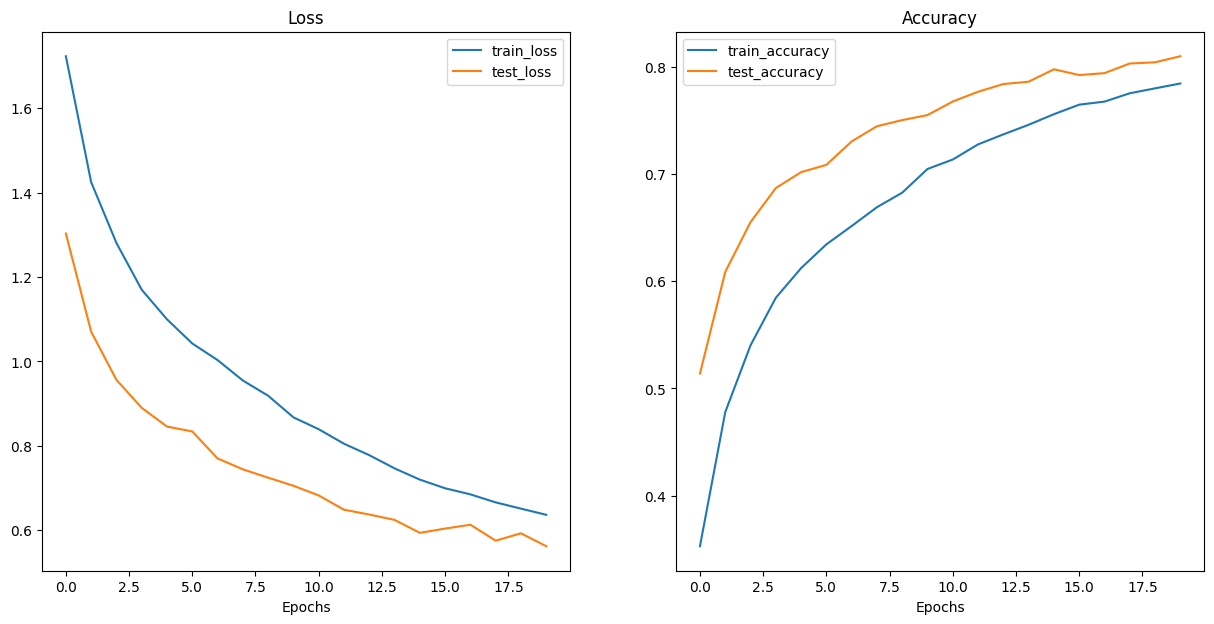

In [97]:
plot_loss_curves(model_1_results)

## 10. Evaluating the Model on Custom Image

In [120]:
custom_image_path = "/content/custom.jpg"

In [121]:
import torchvision
custom_image = torchvision.io.read_image(custom_image_path)
custom_image

tensor([[[ 13,  13,  13,  ...,  15,  15,  16],
         [ 13,  13,  13,  ...,  15,  15,  15],
         [ 13,  13,  13,  ...,  15,  15,  15],
         ...,
         [130, 130, 130,  ..., 113, 114, 115],
         [130, 130, 130,  ..., 113, 114, 115],
         [127, 127, 127,  ..., 113, 114, 115]],

        [[ 10,  10,  10,  ...,  29,  29,  30],
         [ 10,  10,  10,  ...,  29,  29,  29],
         [ 10,  10,  10,  ...,  28,  28,  28],
         ...,
         [158, 158, 158,  ..., 144, 145, 146],
         [158, 158, 158,  ..., 144, 145, 146],
         [158, 158, 158,  ..., 144, 145, 146]],

        [[  3,   3,   3,  ...,   6,   6,   7],
         [  3,   3,   3,  ...,   6,   6,   6],
         [  3,   3,   3,  ...,   8,   8,   8],
         ...,
         [ 83,  83,  83,  ...,  74,  75,  76],
         [ 83,  83,  83,  ...,  74,  75,  76],
         [ 82,  82,  82,  ...,  74,  75,  76]]], dtype=torch.uint8)

(np.float64(-0.5), np.float64(1279.5), np.float64(844.5), np.float64(-0.5))

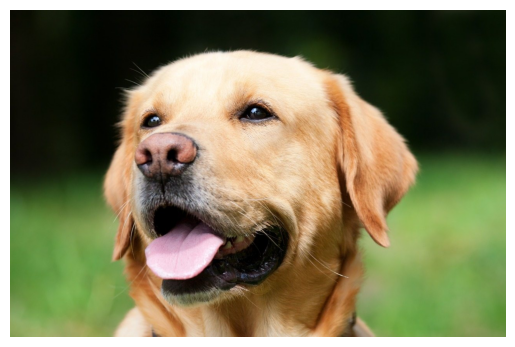

In [122]:
plt.imshow(custom_image.permute(1,2,0))
plt.axis(False)

In [123]:
custom_image = custom_image.type(torch.float32)/255
custom_image.to(device)

tensor([[[0.0510, 0.0510, 0.0510,  ..., 0.0588, 0.0588, 0.0627],
         [0.0510, 0.0510, 0.0510,  ..., 0.0588, 0.0588, 0.0588],
         [0.0510, 0.0510, 0.0510,  ..., 0.0588, 0.0588, 0.0588],
         ...,
         [0.5098, 0.5098, 0.5098,  ..., 0.4431, 0.4471, 0.4510],
         [0.5098, 0.5098, 0.5098,  ..., 0.4431, 0.4471, 0.4510],
         [0.4980, 0.4980, 0.4980,  ..., 0.4431, 0.4471, 0.4510]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.1137, 0.1137, 0.1176],
         [0.0392, 0.0392, 0.0392,  ..., 0.1137, 0.1137, 0.1137],
         [0.0392, 0.0392, 0.0392,  ..., 0.1098, 0.1098, 0.1098],
         ...,
         [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5686, 0.5725],
         [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5686, 0.5725],
         [0.6196, 0.6196, 0.6196,  ..., 0.5647, 0.5686, 0.5725]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0275],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         [0.0118, 0.0118, 0.0118,  ..., 0.0314, 0.0314, 0.

In [124]:
custom_image_transform =transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Normalize(mean, std)
])
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed

tensor([[[-2.2151, -2.1618, -2.0555,  ..., -2.1313, -2.2281, -2.2414],
         [-2.1876, -2.1518, -2.0847,  ..., -2.2758, -2.2929, -2.2684],
         [-2.1481, -2.1530, -2.1440,  ..., -2.2591, -2.2714, -2.2590],
         ...,
         [ 0.0290, -0.1512, -0.1537,  ...,  0.0948, -0.2137, -0.5700],
         [ 0.2774,  0.1860,  0.1819,  ...,  0.1106, -0.1578, -0.5243],
         [ 0.3319,  0.4838,  0.5253,  ...,  0.1166,  0.0076, -0.2766]],

        [[-2.1779, -2.0622, -1.9042,  ..., -1.9300, -1.9964, -1.9745],
         [-2.1592, -2.0684, -1.9496,  ..., -2.0536, -2.0689, -2.0204],
         [-2.1270, -2.0852, -2.0172,  ..., -2.0423, -2.0528, -2.0200],
         ...,
         [ 0.7509,  0.7432,  0.8168,  ...,  0.7543,  0.6447,  0.4710],
         [ 0.8966,  0.9263,  0.8997,  ...,  0.6737,  0.5548,  0.4054],
         [ 0.8559,  0.9823,  0.9733,  ...,  0.5813,  0.5097,  0.4319]],

        [[-2.1619, -2.1288, -2.0313,  ..., -2.0392, -2.1110, -2.1372],
         [-2.1448, -2.1293, -2.0647,  ..., -2

In [125]:
model_1.eval()
with torch.inference_mode():
  pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
  ind = pred.argmax()
class_name = classes_names[ind]
class_name

'dog'

(np.float64(-0.5), np.float64(1279.5), np.float64(844.5), np.float64(-0.5))

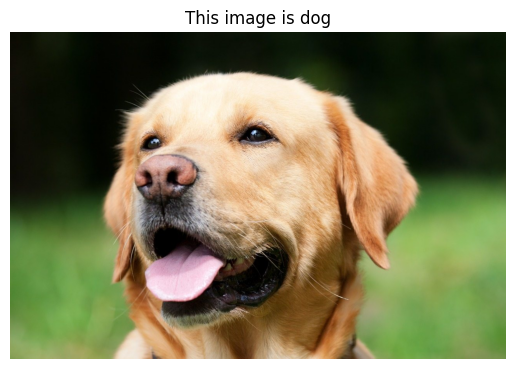

In [126]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"This image is {class_name}")
plt.axis(False)